In [37]:
import requests
from bs4 import BeautifulSoup as soup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [38]:

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/msa?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url, headers=header)


bsObj = soup(raw.content, 'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

print(f"Found {len(listings)} listings")

Found 133 listings


In [39]:
brands = ['yamaha', 'fender', 'gibson', 'ibanez', 'roland', 'korg',
          'marshall', 'vox', 'peavey', 'casio', 'behringer']

instrument_types = ['guitar', 'bass', 'piano', 'keyboard', 'drum', 'amplifier',
                   'amp', 'synthesizer', 'violin', 'saxophone', 'trumpet']

data = []
for listing in listings:
    try:
        title = listing.find('div', class_='title').get_text().lower().strip()

        price_elem = listing.find('div', class_='price')
        price = price_elem.get_text().strip() if price_elem else None

        link_elem = listing.find(href=True)
        link = link_elem['href'] if link_elem else None

        words = title.split()
        brand_hits = [word for word in words if word in brands]
        brand = brand_hits[0] if brand_hits else 'unknown'

        type_hits = [inst_type for inst_type in instrument_types if inst_type in title]
        instrument = type_hits[0] if type_hits else 'other'

        data.append({
            'title': title,
            'price': price,
            'brand': brand,
            'instrument_type': instrument,
            'link': link
        })
    except Exception as e:
        print(f"Error processing listing: {e}")
        continue

print(f"Successfully extracted {len(data)} listings")

Successfully extracted 133 listings


In [40]:
df = pd.DataFrame(data)

df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df = df.dropna(subset=['price'])

print(f"Total listings with prices: {len(df)}")
print(df.head())

Total listings with prices: 133
                                             title  price    brand  \
0                 original 50's kay archtop & back    350  unknown   
1         ada mp1 tube guitar pre & mc1 controller    750  unknown   
2                              vintage aulos flute     10  unknown   
3                 audient asp800 8 channel mic pre    800  unknown   
4  vintage yamaha japan jx40 1x12 guitar amplifier    250   yamaha   

  instrument_type                                               link  
0           other  https://charlottesville.craigslist.org/msg/d/c...  
1          guitar  https://charlottesville.craigslist.org/msg/d/c...  
2           other  https://charlottesville.craigslist.org/msg/d/t...  
3           other  https://charlottesville.craigslist.org/msg/d/c...  
4          guitar  https://charlottesville.craigslist.org/msg/d/g...  


In [41]:
print("Price Statistics:")
print(df['price'].describe())

print("\nAverage price by instrument type:")
print(df.groupby('instrument_type')['price'].agg(['mean', 'count', 'median']).sort_values('mean', ascending=False))

print("\nAverage price by brand:")
print(df.groupby('brand')['price'].agg(['mean', 'count', 'median']).sort_values('mean', ascending=False))

Price Statistics:
count     133.000000
mean      556.924812
std      1029.513563
min         0.000000
25%       100.000000
50%       280.000000
75%       600.000000
max      8950.000000
Name: price, dtype: float64

Average price by instrument type:
                        mean  count  median
instrument_type                            
piano            1933.444444      9   280.0
synthesizer      1500.000000      1  1500.0
drum              650.000000      5   550.0
amplifier         597.500000      2   597.5
other             488.975309     81   250.0
amp               417.857143      7   350.0
bass              312.800000      5   250.0
guitar            296.619048     21   250.0
keyboard          200.000000      2   200.0

Average price by brand:
                mean  count  median
brand                              
gibson   1166.666667      3   500.0
ibanez    877.750000      4   355.0
fender    746.250000     12   645.0
yamaha    660.000000      5   600.0
korg      650.000000      

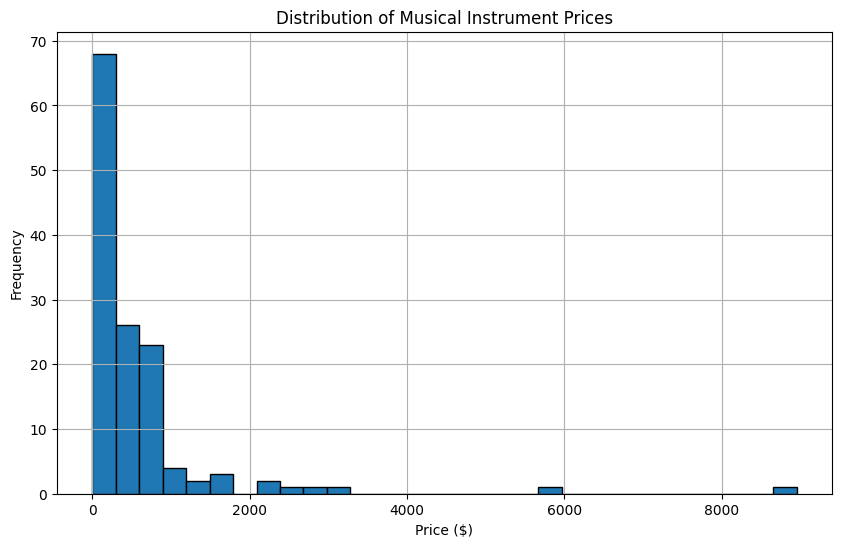

In [42]:
# Graph 1
plt.figure(figsize=(10, 6))
df['price'].hist(bins=30, edgecolor='black')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Musical Instrument Prices')
plt.show()

/tmp/ipython-input-3516029663.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/tmp/ipython-input-3516029663.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


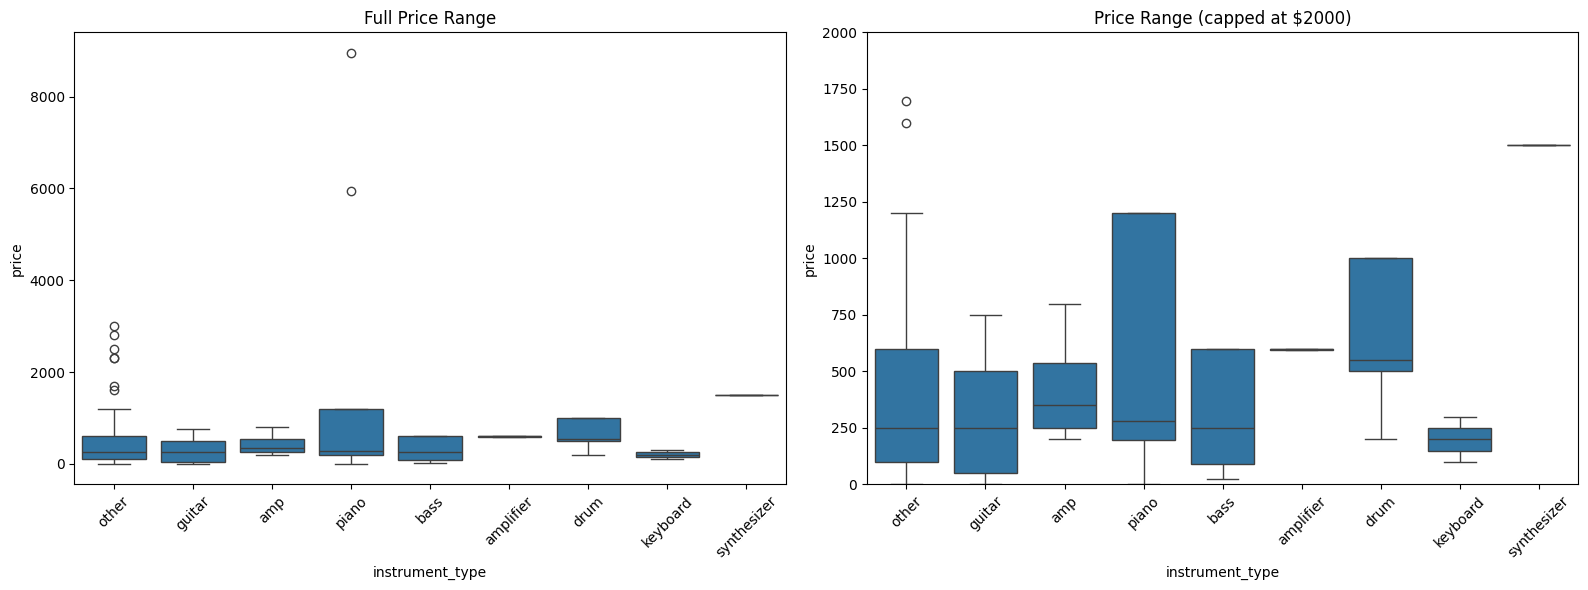

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1:
sns.boxplot(data=df, x='instrument_type', y='price', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_title('Full Price Range')

# Plot 2:
sns.boxplot(data=df, x='instrument_type', y='price', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_ylim(0, 2000)
ax2.set_title('Price Range (capped at $2000)')

plt.tight_layout()
plt.show()

In [44]:
price_by_type = df.groupby('instrument_type')['price'].agg(['median', 'mean', 'count', 'std'])
price_by_type = price_by_type.sort_values('median', ascending=False)

print("Price Analysis by Instrument Type:")
print(price_by_type)

price_by_type['cv'] = price_by_type['std'] / price_by_type['mean']
print("\nPrice Consistency (lower = more consistent):")
print(price_by_type[['cv']].sort_values('cv'))

#Pianos have the highest median price ($X) but also the highest price variation, suggesting a wide quality range. Amplifiers show the most consistent pricing, indicating a more standardized market.

Price Analysis by Instrument Type:
                 median         mean  count          std
instrument_type                                         
synthesizer      1500.0  1500.000000      1          NaN
amplifier         597.5   597.500000      2     3.535534
drum              550.0   650.000000      5   346.410162
amp               350.0   417.857143      7   228.543525
piano             280.0  1933.444444      9  3237.440815
guitar            250.0   296.619048     21   280.144334
bass              250.0   312.800000      5   274.752980
other             250.0   488.975309     81   641.278586
keyboard          200.0   200.000000      2   141.421356

Price Consistency (lower = more consistent):
                       cv
instrument_type          
amplifier        0.005917
drum             0.532939
amp              0.546942
keyboard         0.707107
bass             0.878366
guitar           0.944458
other            1.311474
piano            1.674442
synthesizer           NaN
